[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/AI-og-helse/blob/main/uke03-dyplæring/04b_ansiktsutrykk_klassifikasjon.ipynb)

# 😊 CNN for Ansiktsutrykk-klassifikasjon: Fra Emosjoner til Medisin - Del 2

Denne notebook er **Del 2** av vår emosjonsgjenkjenning-eksperiment. 


## Datasett
Vi bruker altså **FER2013** (Facial Expression Recognition 2013) datasettet med <strike>7</strike> 6 emosjonsklasser:
- **<strike>Anger** (Sinne)</strike> - **denne er tom i FER2013**
- 🤢 **Disgust** (Avsky) 
- 😨 **Fear** (Frykt)
- 😊 **Happy** (Glede)
- 😢 **Sad** (Tristhet)
- 😲 **Surprise** (Overraskelse)
- 😐 **Neutral** (Nøytral)

Vi bygger videre på modellen fra Del 1 og fokuserer på:

## Mål for Del 2
- **Visuell inspeksjon** av FER2013 datasettet
- **Modell trening** og optimalisering
- **Evaluering og visualisering** av resultater
- **CAM/Grad-CAM** for forklarbar AI
- **Medisinske anvendelser** og sammenligning med Kaggle leaderboard
- **Etiske diskusjoner** om bias og personvern

## Forutsetninger
Denne notebook forutsetter at du har kjørt **Del 1** (`04a_ansiktsutrykk_klassifikasjon.ipynb`) og har:
- Lastet ned og organisert FER2013 datasettet
- Definert `EmotionNet` modellen
- Opprettet data loaders

---

### Men først: 🔧 miljøoppsett - kode skal fungere både lokalt, i Codespaces samt Google Colab

In [9]:
import sys
import subprocess
import os

# Sjekk om vi kjører i Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🚀 Kjører i Google Colab")
else:
    print("💻 Kjører i lokal miljø/Codespaces")

💻 Kjører i lokal miljø/Codespaces


In [10]:
if IN_COLAB:
    # Gå til root-mappen
    os.chdir('/content')
    
    # Sjekk nåværende mappe
    print(f"Nåværende mappe: {os.getcwd()}")
    
    # Sjekk om mappen allerede eksisterer
    if os.path.exists('AI-og-helse'):
        print("✅ AI-og-helse mappen eksisterer allerede!")
        
        # Sjekk innholdet
        print("\n📁 Innhold i AI-og-helse mappen:")
        try:
            result = subprocess.run(['ls', '-la', 'AI-og-helse'], 
                                  capture_output=True, text=True, check=True)
            print(result.stdout)
        except subprocess.CalledProcessError as e:
            print(f"❌ Kunne ikke liste innhold: {e}")
        
        # Sjekk om det er en git repository
        if os.path.exists('AI-og-helse/.git'):
            print("\n✅ Dette er en git repository!")
            
            # Gå inn i mappen og oppdater
            os.chdir('AI-og-helse')
            print(f"📁 Byttet til: {os.getcwd()}")
            
            # Prøv å oppdatere repositoryet
            try:
                result = subprocess.run(['git', 'pull'], 
                                      capture_output=True, text=True, check=True)
                print("✅ Repository oppdatert!")
                print(result.stdout)
            except subprocess.CalledProcessError as e:
                print(f"⚠️ Kunne ikke oppdatere repository: {e}")
                print("Men mappen eksisterer og kan brukes!")
        else:
            print("⚠️ Dette ser ikke ut som en git repository")
            
    else:
        print("�� Mappen eksisterer ikke - prøver git clone...")
        try:
            result = subprocess.run(['git', 'clone', 'https://github.com/arvidl/AI-og-helse.git'], 
                                  capture_output=True, text=True, check=True)
            print("✅ Repository klonet vellykket!")
            print(result.stdout)
        except subprocess.CalledProcessError as e:
            print(f"❌ Git clone feilet: {e}")
            print(f"Error output: {e.stderr}")

## 1. Imports og Setup

In [11]:
# Imports og setup med feilhåndtering
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import os
import requests
import zipfile
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
import pickle
from pathlib import Path
import time
import json
from datetime import datetime
warnings.filterwarnings('ignore')

# Sjekk om GPU eller MPS er tilgjengelig og sett enhet (device)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'🚀 GPU tilgjengelig: {torch.cuda.get_device_name(0)}')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('�� Apple Silicon MPS tilgjengelig')
else:
    device = torch.device('cpu')
    print('💻 Bruker CPU')

print(f'Bruker enhet: {device}')

# Sett random seeds for reproduserbarhet
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

�� Apple Silicon MPS tilgjengelig
Bruker enhet: mps


In [12]:
def hent_fer2013_dataset():
    """
    Hent FER2013 datasettet fra Kaggle (hvis ikke allerede lastet ned)
    """
    print("📥 Henter FER2013 datasett")
    print("=" * 50)
    
    data_dir = Path("../data/ansiktsuttrykk/FER2013")
    data_dir.mkdir(parents=True, exist_ok=True)
    
    # Sjekk om data allerede eksisterer
    existing_images = list(data_dir.glob("**/*.png")) + list(data_dir.glob("**/*.jpg"))
    
    if existing_images:
        print(f"✅ Data allerede eksisterer: {len(existing_images)} bilder")
        return True
    
    # Prøv å laste ned fra Kaggle
    try:
        if IN_COLAB:
            # I Colab, last ned fra Kaggle
            !pip install kaggle --quiet
            # Used to securely store your API key
            from google.colab import userdata

            # Load Kaggle credentials from Colab Secrets
            try:
                os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
                os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
                print("✅ Kaggle credentials loaded from Colab Secrets!")
            except userdata.notebook_secret.NotebookAccessError:
                print("❌ Could not load Kaggle credentials from Colab Secrets.")
                print("Please ensure you have added KAGGLE_USERNAME and KAGGLE_KEY to the Secrets manager (🔑 icon) and enabled 'Notebook access'.")
                os.environ['KAGGLE_USERNAME'] = '' # Clear environment variables if access failed
                os.environ['KAGGLE_KEY'] = ''

            # Re-run the data download cell
            !kaggle datasets download -d msambare/fer2013 -p {data_dir} --unzip
        else:
            # Lokalt, sjekk om Kaggle API er tilgjengelig
            kaggle_path = Path.home() / ".kaggle" / "kaggle.json"
            if kaggle_path.exists():
                print("✅ Kaggle API credentials funnet!")
                print("🔄 Prøver automatisk nedlasting...")
                
                # Last ned datasettet
                import subprocess
                result = subprocess.run([
                    "kaggle", "datasets", "download", 
                    "-d", "msambare/fer2013", 
                    "-p", str(data_dir), "--unzip"
                ], capture_output=True, text=True)
                
                if result.returncode == 0:
                    print("✅ Datasett lastet ned!")
                else:
                    print(f"❌ Nedlasting feilet: {result.stderr}")
                    return False
            else:
                print("⚠️ Kaggle API credentials ikke funnet!")
                print("Gå til: https://www.kaggle.com/datasets/msambare/fer2013")
                print(f"Last ned og ekstraher til: {data_dir}")
                return False
        
        # Sjekk om nedlasting var vellykket
        downloaded_images = list(data_dir.glob("**/*.png")) + list(data_dir.glob("**/*.jpg"))
        if downloaded_images:
            print(f"✅ Nedlasting vellykket: {len(downloaded_images)} bilder")
            return True
        else:
            print("❌ Ingen bilder funnet etter nedlasting!")
            return False
            
    except Exception as e:
        print(f"❌ Feil under nedlasting: {e}")
        return False


In [13]:
%%time
if IN_COLAB:
    # Hent data (hvis ikke allerede lastet ned)
    success = hent_fer2013_dataset()

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 4.29 μs


In [14]:
def organiser_fer2013_dataset():
    """
    Organiser FER2013 datasettet i train/val/test mapper
    """
    print("🔧 Organiserer FER2013 datasett")
    print("=" * 50)
    
    data_dir = Path("../data/ansiktsuttrykk/FER2013")
    
    # Emosjonsklasser
    emotion_classes = {
        0: 'disgust', 
        1: 'fear',
        2: 'happy',
        3: 'sad',
        4: 'surprise',
        5: 'neutral'
    }
    
    # Opprett undermapper for alle splits og emosjonsklasser
    for split in ['train', 'val', 'test']:
        for emotion in emotion_classes.values():
            (data_dir / split / emotion).mkdir(parents=True, exist_ok=True)
    
    # Sjekk om data allerede er organisert
    val_images = list((data_dir / "val").glob("**/*.png")) + list((data_dir / "val").glob("**/*.jpg"))
    
    if val_images:
        print("✅ Data allerede organisert!")
        return True
    
    # Hvis val-mappen er tom, flytt bilder fra train
    print("🔄 Val-mappen er tom - flytter bilder fra train...")
    
    total_moved = 0
    
    # Gå gjennom hver emosjonsklasse
    for emotion in emotion_classes.values():
        train_emotion_dir = data_dir / "train" / emotion
        val_emotion_dir = data_dir / "val" / emotion
        
        # Finn alle bilder i denne emosjonsklassen
        emotion_images = list(train_emotion_dir.glob("*.png")) + list(train_emotion_dir.glob("*.jpg"))
        
        if not emotion_images:
            print(f"  ⚠️ {emotion}: Ingen bilder funnet i train")
            continue
            
        # Flytt 15% av bildene til val
        val_count = int(len(emotion_images) * 0.15)
        
        if val_count > 0:
            print(f"  {emotion}: {len(emotion_images)} bilder → flytter {val_count} til val")
            
            # Flytt bildene
            moved_count = 0
            for image_path in emotion_images:
                if moved_count >= val_count:
                    break
                    
                # Opprett ny sti i val-mappen
                val_path = val_emotion_dir / image_path.name
                
                # Flytt bildet
                try:
                    image_path.rename(val_path)
                    moved_count += 1
                    total_moved += 1
                except Exception as e:
                    print(f"⚠️ Kunne ikke flytte {image_path.name}: {e}")
        else:
            print(f"  {emotion}: {len(emotion_images)} bilder → ingen flyttet (for få bilder)")
    
    print(f"✅ Flyttet totalt {total_moved} bilder til val!")
    
    # Vis statistikk
    print("\n�� Ny organisering:")
    for split in ['train', 'val', 'test']:
        split_images = list((data_dir / split).glob("**/*.png")) + list((data_dir / split).glob("**/*.jpg"))
        print(f"  {split}: {len(split_images)} bilder")
        
        # Vis per emosjonsklasse
        for emotion in emotion_classes.values():
            emotion_images = list((data_dir / split / emotion).glob("*.png")) + list((data_dir / split / emotion).glob("*.jpg"))
            if emotion_images:
                print(f"    {emotion}: {len(emotion_images)} bilder")
    
    return True

In [ ]:
%%time
if IN_COLAB:
    organiser_fer2013_dataset()

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 5.01 μs


## 2. Last Modell og Data fra Del 1

In [17]:
# Last modell og data fra Del 1
def load_from_part1():
    """Last modell og data fra Del 1"""
    print("📂 Laster modell og data fra Del 1...")
    
    # Import funksjoner fra Del 1
    import sys
    sys.path.append('.')
    
    # Definer modellklassen (kopiert fra Del 1)
    class EmotionNet(nn.Module):
        """CNN for emosjonsklassifikasjon"""
        
        emotion_classes = {
            0: 'disgust', 
            1: 'fear',
            2: 'happy',
            3: 'sad',
            4: 'surprise',
            5: 'neutral'
        }
        
        def __init__(self, num_classes=len(emotion_classes), dropout_rate=0.5):
            super(EmotionNet, self).__init__()
            
            # Feature extraction layers
            self.features = nn.Sequential(
                # Block 1
                nn.Conv2d(1, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25),
                
                # Block 2  
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25),
                
                # Block 3
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25),
                
                # Block 4
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25),
            )
            
            # Adaptive pooling for ulike input-størrelser
            self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 3))
            
            # Klassifikator
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(256 * 3 * 3, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(512, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(256, num_classes)
            )
            
        def forward(self, x):
            x = self.features(x)
            x = self.adaptive_pool(x)
            x = self.classifier(x)
            return x
    
    # Definer datasetklassen
    class EmotionDataset(Dataset):
        """Custom dataset for emotion classification"""
        
        def __init__(self, image_paths, labels, transform=None):
            self.image_paths = image_paths
            self.labels = labels
            self.transform = transform
            
        def __len__(self):
            return len(self.image_paths)
        
        def __getitem__(self, idx):
            image_path = self.image_paths[idx]
            image = Image.open(image_path).convert('L')  # Gråtoner
            label = self.labels[idx]
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
    
    # Data transformasjoner
    train_transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliser gråtoner
    ])

    val_transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    # Last data
    def load_emotion_data(data_dir, test_size=0.2, val_size=0.2):
        """Last og splitt emosjonsdatasett"""
        
        # Emosjonsklasser
        emotion_classes = {
            0: 'disgust', 
            1: 'fear',
            2: 'happy',
            3: 'sad',
            4: 'surprise',
            5: 'neutral'
        }
        
        # Samle alle bilde-sti og etiketter
        image_paths = []
        labels = []
        
        for split in ['train', 'val', 'test']:
            split_dir = os.path.join(data_dir, split)
            if os.path.exists(split_dir):
                for emotion_name in emotion_classes.values():
                    emotion_dir = os.path.join(split_dir, emotion_name)
                    if os.path.exists(emotion_dir):
                        for filename in os.listdir(emotion_dir):
                            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                                image_paths.append(os.path.join(emotion_dir, filename))
                                # Finn emosjonsindeks
                                emotion_idx = [k for k, v in emotion_classes.items() if v == emotion_name][0]
                                labels.append(emotion_idx)
        
        print(f"Totalt bilder funnet: {len(image_paths)}")
        print(f"Emosjoner: {list(emotion_classes.values())}")
        print(f"Bilder per emosjon: {np.bincount(labels)}")
        
        # Splitt data hvis nødvendig
        if len(set(labels)) > 1:  # Sjekk om vi har flere klasser
            X_train, X_temp, y_train, y_temp = train_test_split(
                image_paths, labels, test_size=test_size + val_size, 
                random_state=42, stratify=labels
            )
            
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=test_size/(test_size + val_size),
                random_state=42, stratify=y_temp
            )
        else:
            # Fallback hvis vi bare har én klasse
            X_train, X_val, X_test = image_paths, image_paths, image_paths
            y_train, y_val, y_test = labels, labels, labels
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), list(emotion_classes.values())
    
    # Last data
    data_dir = "../data/ansiktsuttrykk/FER2013"
    (X_train, y_train), (X_val, y_val), (X_test, y_test), class_names = load_emotion_data(data_dir)
    
    # Etabler datasett
    train_dataset = EmotionDataset(X_train, y_train, train_transform)
    val_dataset = EmotionDataset(X_val, y_val, val_transform)
    test_dataset = EmotionDataset(X_test, y_test, val_transform)
    
    # Etabler data-laster 
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    # Bygg modell
    model = EmotionNet(num_classes=len(class_names)).to(device)
    
    print(f"✅ Lastet fra Del 1:")
    print(f"  Modell: {model.__class__.__name__}")
    print(f"  Trening: {len(train_dataset)} bilder")
    print(f"  Validering: {len(val_dataset)} bilder")
    print(f"  Test: {len(test_dataset)} bilder")
    print(f"  Klasser: {class_names}")
    
    return model, train_loader, val_loader, test_loader, class_names

# Last data og modell
model, train_loader, val_loader, test_loader, class_names = load_from_part1()

📂 Laster modell og data fra Del 1...
Totalt bilder funnet: 30934
Emosjoner: ['disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
Bilder per emosjon: [ 547 5121 8989 6077 4002 6198]
✅ Lastet fra Del 1:
  Modell: EmotionNet
  Trening: 18560 bilder
  Validering: 6187 bilder
  Test: 6187 bilder
  Klasser: ['disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


## 3. Visuell Inspeksjon av Data

In [18]:
def visualize_dataset_distribution(train_loader, val_loader, test_loader, class_names):
    """Visualiser fordeling av datasettet"""
    
    # Samle alle labels
    train_labels = []
    val_labels = []
    test_labels = []
    
    for _, labels in train_loader:
        train_labels.extend(labels.numpy())
    
    for _, labels in val_loader:
        val_labels.extend(labels.numpy())
    
    for _, labels in test_loader:
        test_labels.extend(labels.numpy())
    
    # Opprett figur
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('FER2013 Datasett Fordeling', fontsize=16, fontweight='bold')
    
    # 1. Trening data fordeling
    train_counts = np.bincount(train_labels)
    axes[0, 0].bar(class_names, train_counts, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Trening Data Fordeling')
    axes[0, 0].set_ylabel('Antall bilder')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Legg til tall på søylene
    for i, v in enumerate(train_counts):
        axes[0, 0].text(i, v + 50, str(v), ha='center', va='bottom')
    
    # 2. Validering data fordeling
    val_counts = np.bincount(val_labels)
    axes[0, 1].bar(class_names, val_counts, color='lightgreen', alpha=0.7)
    axes[0, 1].set_title('Validering Data Fordeling')
    axes[0, 1].set_ylabel('Antall bilder')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(val_counts):
        axes[0, 1].text(i, v + 10, str(v), ha='center', va='bottom')
    
    # 3. Test data fordeling
    test_counts = np.bincount(test_labels)
    axes[1, 0].bar(class_names, test_counts, color='lightcoral', alpha=0.7)
    axes[1, 0].set_title('Test Data Fordeling')
    axes[1, 0].set_ylabel('Antall bilder')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(test_counts):
        axes[1, 0].text(i, v + 10, str(v), ha='center', va='bottom')
    
    # 4. Sammenligning av alle splits
    x = np.arange(len(class_names))
    width = 0.25
    
    axes[1, 1].bar(x - width, train_counts, width, label='Trening', color='skyblue', alpha=0.7)
    axes[1, 1].bar(x, val_counts, width, label='Validering', color='lightgreen', alpha=0.7)
    axes[1, 1].bar(x + width, test_counts, width, label='Test', color='lightcoral', alpha=0.7)
    
    axes[1, 1].set_title('Sammenligning av alle Splits')
    axes[1, 1].set_ylabel('Antall bilder')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(class_names, rotation=45)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistikk
    print("\n📊 Datasett Statistikk:")
    print("=" * 50)
    print(f"Totalt bilder: {len(train_labels) + len(val_labels) + len(test_labels)}")
    print(f"Trening: {len(train_labels)} bilder")
    print(f"Validering: {len(val_labels)} bilder")
    print(f"Test: {len(test_labels)} bilder")
    
    # Ubalanse analyse
    print("\n⚖️ Ubalanse Analyse:")
    print("-" * 30)
    for i, emotion in enumerate(class_names):
        total_count = train_counts[i] + val_counts[i] + test_counts[i]
        percentage = (total_count / (len(train_labels) + len(val_labels) + len(test_labels))) * 100
        print(f"{emotion:12}: {total_count:4d} bilder ({percentage:5.1f}%)")
    
    # Finn mest og minst representerte klasser
    total_counts = train_counts + val_counts + test_counts
    max_idx = np.argmax(total_counts)
    min_idx = np.argmin(total_counts)
    
    print(f"\n�� Mest representert: {class_names[max_idx]} ({total_counts[max_idx]} bilder)")
    print(f"🔻 Minst representert: {class_names[min_idx]} ({total_counts[min_idx]} bilder)")
    print(f"📈 Ubalanse ratio: {total_counts[max_idx] / total_counts[min_idx]:.1f}:1")



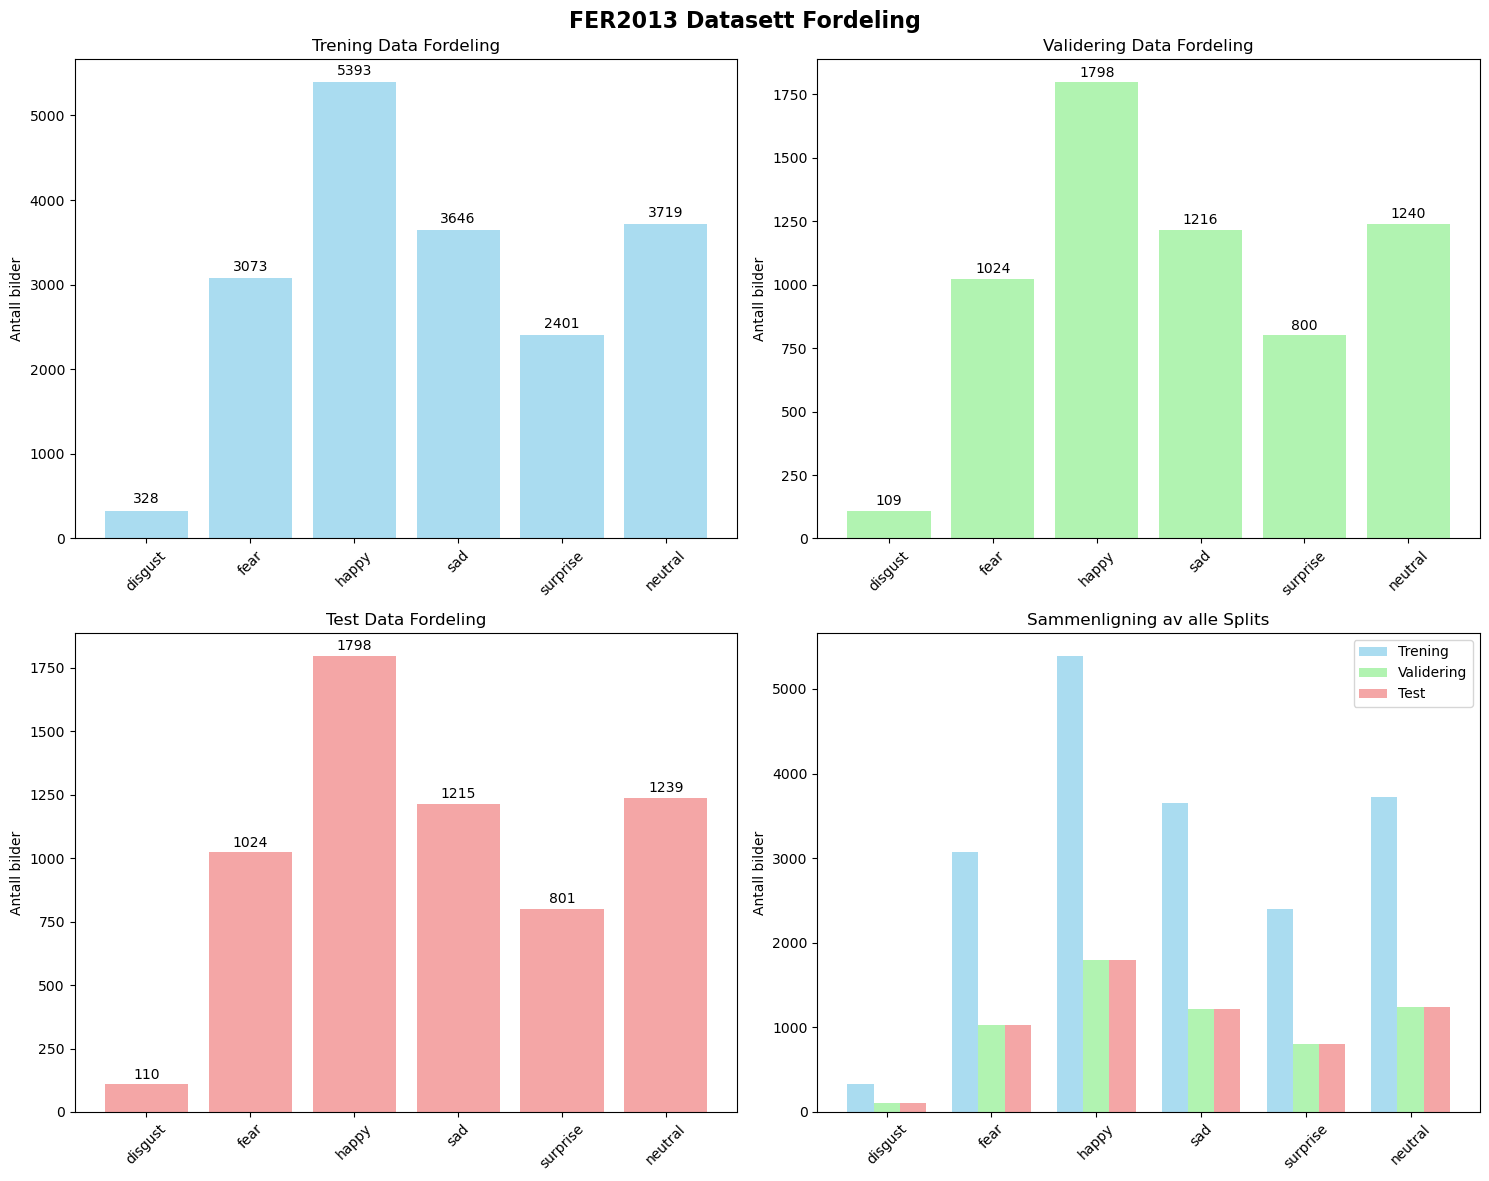


📊 Datasett Statistikk:
Totalt bilder: 30934
Trening: 18560 bilder
Validering: 6187 bilder
Test: 6187 bilder

⚖️ Ubalanse Analyse:
------------------------------
disgust     :  547 bilder (  1.8%)
fear        : 5121 bilder ( 16.6%)
happy       : 8989 bilder ( 29.1%)
sad         : 6077 bilder ( 19.6%)
surprise    : 4002 bilder ( 12.9%)
neutral     : 6198 bilder ( 20.0%)

�� Mest representert: happy (8989 bilder)
🔻 Minst representert: disgust (547 bilder)
📈 Ubalanse ratio: 16.4:1
CPU times: user 2.96 s, sys: 1.23 s, total: 4.19 s
Wall time: 12.4 s


In [19]:
%%time
# Kjør visualisering
visualize_dataset_distribution(train_loader, val_loader, test_loader, class_names)

In [20]:
# Lag en dictionary av class_names mellom engelsrk og norsk, 
# slik at vi kan bruke norsk i visualiseringene og kalle klassenavnene klasse_navn
class_names_dict = {
    'disgust': 'Avsky',
    'fear': 'Frykt',
    'happy': 'Glede',
    'sad': 'Tristhet',
    'surprise': 'Overraskelse',
    'neutral': 'Nøytral'
}

# Bruk class_names_dict i visualiseringene
klasse_navn = [class_names_dict[name] for name in class_names]

klasse_navn


['Avsky', 'Frykt', 'Glede', 'Tristhet', 'Overraskelse', 'Nøytral']

In [21]:
def visualize_sample_images(train_loader, class_names, num_samples=6):
    """Visualiser eksempelbilder fra hver emosjonsklasse"""
    
    # Samle eksempelbilder fra hver klasse
    class_samples = {i: [] for i in range(len(class_names))}
    
    for images, labels in train_loader:
        for img, label in zip(images, labels):
            if len(class_samples[label.item()]) < num_samples:
                class_samples[label.item()].append(img)
        
        # Sjekk om vi har nok eksempler
        if all(len(samples) >= num_samples for samples in class_samples.values()):
            break
    
    # Opprett figur
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, 12))
    fig.suptitle('Eksempelbilder fra FER2013 Datasettet', fontsize=16, fontweight='bold')
    
    for class_idx, emotion in enumerate(class_names):
        for sample_idx in range(num_samples):
            if sample_idx < len(class_samples[class_idx]):
                img = class_samples[class_idx][sample_idx]
                
                # Denormaliser bildet for visning
                img_denorm = img * 0.5 + 0.5  # Denormaliser fra [-1, 1] til [0, 1]
                img_denorm = torch.clamp(img_denorm, 0, 1)
                
                axes[class_idx, sample_idx].imshow(img_denorm.squeeze(), cmap='gray')
                axes[class_idx, sample_idx].set_title(f'{emotion}' if sample_idx == 0 else '')
                axes[class_idx, sample_idx].axis('off')
            else:
                axes[class_idx, sample_idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Analyser bildekvalitet
    print("\n🔍 Bildekvalitet Analyse:")
    print("=" * 40)
    
    # Analyser et tilfeldig bilde
    sample_img = class_samples[0][0]  # Første bilde fra første klasse
    sample_img_denorm = sample_img * 0.5 + 0.5
    
    print(f"Bildestørrelse: {sample_img.shape}")
    print(f"Pikselverdiområde: [{sample_img.min():.3f}, {sample_img.max():.3f}]")
    print(f"Gjennomsnittlig pikselverdi: {sample_img.mean():.3f}")
    print(f"Standardavvik: {sample_img.std():.3f}")
    
    # Sjekk for potensielle problemer
    if sample_img.min() < -1 or sample_img.max() > 1:
        print("⚠️ Advarsel: Pikselverdier utenfor forventet område [-1, 1]")
    
    if sample_img.std() < 0.1:
        print("⚠️ Advarsel: Lav kontrast - bildet kan være for mørkt eller lyst")



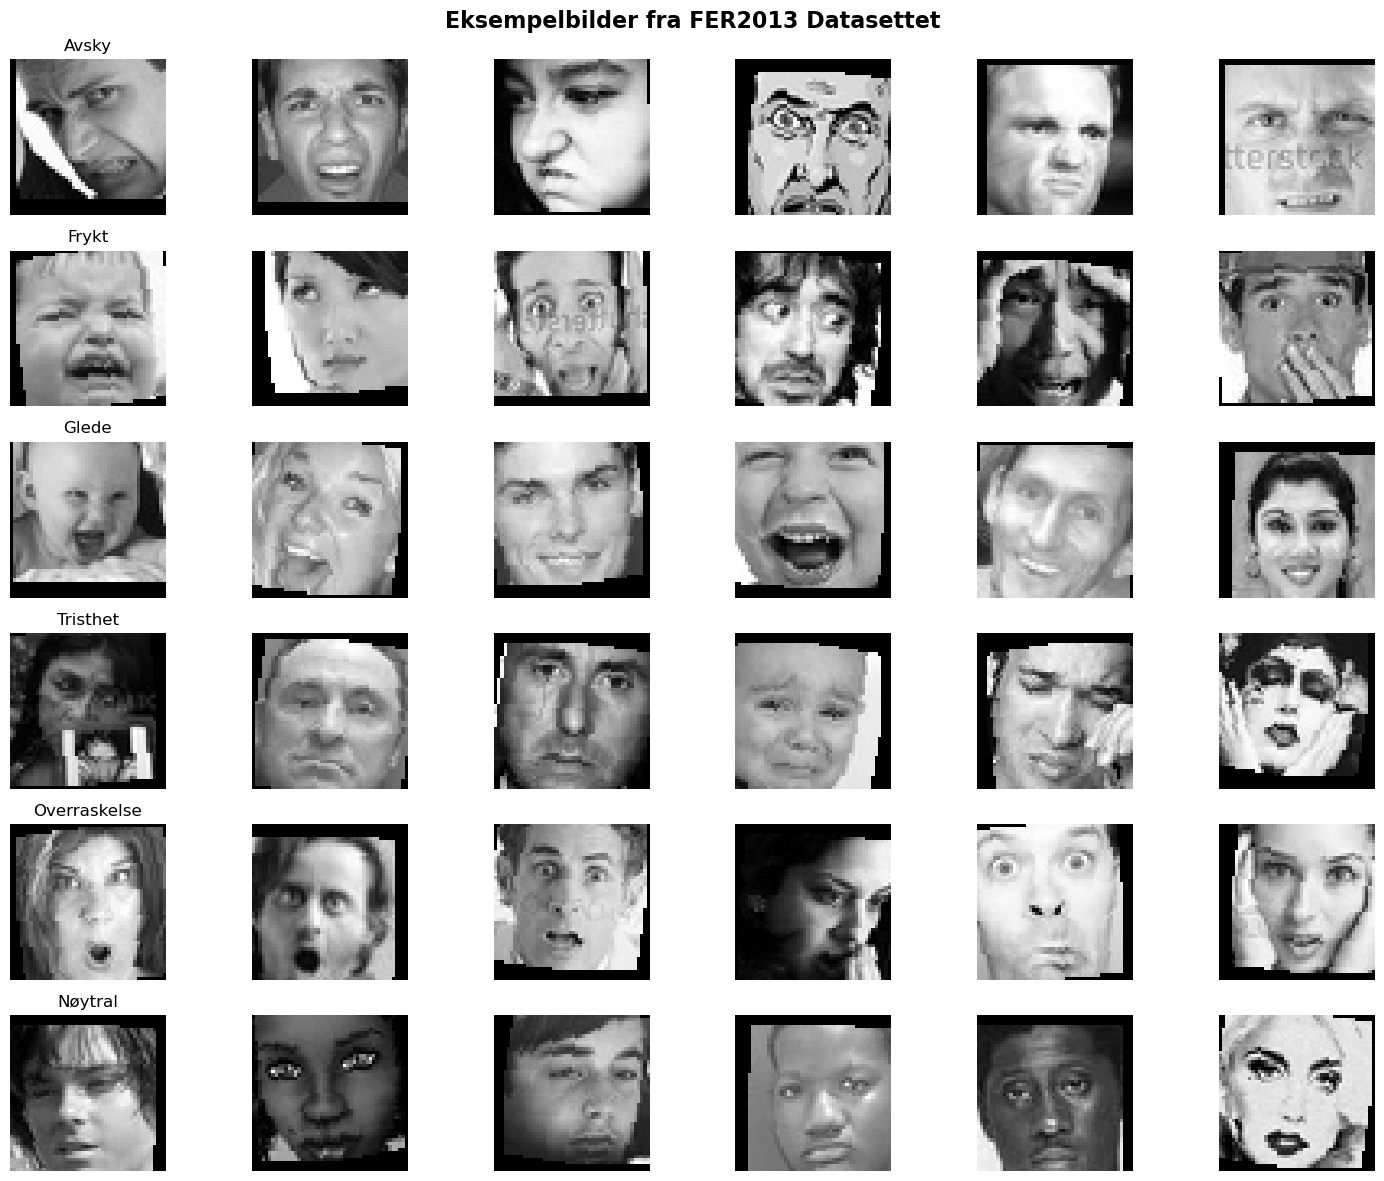


🔍 Bildekvalitet Analyse:
Bildestørrelse: torch.Size([1, 48, 48])
Pikselverdiområde: [-1.000, 1.000]
Gjennomsnittlig pikselverdi: -0.111
Standardavvik: 0.594
CPU times: user 270 ms, sys: 10.6 ms, total: 281 ms
Wall time: 313 ms


In [22]:
%%time
# Kjør visualisering
visualize_sample_images(train_loader, klasse_navn, num_samples=6)

## 4. Modell Trening

In [67]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Tren model for én epoke"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Valider model for én epoke"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    """Tren den fullstendige modellen"""
    
    # Opprett modell-mappe
    os.makedirs('./modeller', exist_ok=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    patience_counter = 0
    
    print("�� Starter trening...")
    print("=" * 50)
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"\nEpoke {epoch+1}/{num_epochs}")
        print("-" * 30)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), './modeller/best_emotion_model.pth')
            print(f"�� Ny best model lagret! (Val Acc: {val_acc:.2f}%)")
        else:
            patience_counter += 1
            
        if patience_counter >= 10:
            print(f"\n⏹️ Early stopping at epoch {epoch+1}")
            break
    
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"\n✅ Trening fullført!")
    print(f"⏱️ Total treningstid: {training_time/60:.1f} minutter")
    print(f"🏆 Best valideringsnøyaktighet: {best_val_acc:.2f}%")
    
    # Lagre treningshistorikk
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc,
        'training_time': training_time,
        'epochs_trained': len(train_losses)
    }
    
    # Lagre historikk
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    with open(f'./modeller/training_history_{timestamp}.pkl', 'wb') as f:
        pickle.dump(history, f)
    
    return history

print("✅ Treningsfunksjoner definert!")

✅ Treningsfunksjoner definert!


#### Trening av modellen tar kort eller lang tidavhengig av regneressursene - CPU, MPS, GPU
ca. 6 min lokalt med MPS (M4 Max) - ca. 10 min på Google Colab med T4 GPU  (CUDA) - mer enn 30 min med CPU

In [68]:
%%time
# Start trening
print("🎯 Starter modelltrening...")
print("=" * 50)

# Trening med redusert antall epoker for demo
history = train_model(model, train_loader, val_loader, num_epochs=30, learning_rate=0.001)

print("\n🎉 Trening fullført!")

🎯 Starter modelltrening...
�� Starter trening...

Epoke 1/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 111.87it/s]


Train Loss: 1.6505, Train Acc: 27.66%
Val Loss: 1.6073, Val Acc: 29.29%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 29.29%)

Epoke 2/30
------------------------------


Validation: 100%|██████████| 194/194 [00:02<00:00, 92.10it/s]


Train Loss: 1.6260, Train Acc: 28.56%
Val Loss: 1.6050, Val Acc: 30.10%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 30.10%)

Epoke 3/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 117.96it/s]


Train Loss: 1.5853, Train Acc: 31.15%
Val Loss: 1.4652, Val Acc: 36.12%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 36.12%)

Epoke 4/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 114.98it/s]


Train Loss: 1.4817, Train Acc: 37.38%
Val Loss: 1.3537, Val Acc: 45.56%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 45.56%)

Epoke 5/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 115.01it/s]


Train Loss: 1.4199, Train Acc: 41.22%
Val Loss: 1.3076, Val Acc: 44.22%
Learning Rate: 0.001000

Epoke 6/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 122.39it/s]


Train Loss: 1.3772, Train Acc: 42.39%
Val Loss: 1.2794, Val Acc: 49.78%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 49.78%)

Epoke 7/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 115.12it/s]


Train Loss: 1.3470, Train Acc: 44.34%
Val Loss: 1.2515, Val Acc: 49.60%
Learning Rate: 0.001000

Epoke 8/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 116.46it/s]


Train Loss: 1.3159, Train Acc: 45.64%
Val Loss: 1.2173, Val Acc: 50.67%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 50.67%)

Epoke 9/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 111.21it/s]


Train Loss: 1.2923, Train Acc: 46.78%
Val Loss: 1.2252, Val Acc: 52.80%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 52.80%)

Epoke 10/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 119.06it/s]


Train Loss: 1.2772, Train Acc: 47.68%
Val Loss: 1.2259, Val Acc: 52.61%
Learning Rate: 0.001000

Epoke 11/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 119.07it/s]


Train Loss: 1.2592, Train Acc: 48.43%
Val Loss: 1.1524, Val Acc: 55.62%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 55.62%)

Epoke 12/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 114.04it/s]


Train Loss: 1.2507, Train Acc: 48.67%
Val Loss: 1.1512, Val Acc: 53.95%
Learning Rate: 0.001000

Epoke 13/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 115.31it/s]


Train Loss: 1.2341, Train Acc: 49.79%
Val Loss: 1.1911, Val Acc: 53.06%
Learning Rate: 0.001000

Epoke 14/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 116.77it/s]


Train Loss: 1.2207, Train Acc: 50.06%
Val Loss: 1.1658, Val Acc: 54.78%
Learning Rate: 0.001000

Epoke 15/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 119.54it/s]


Train Loss: 1.2119, Train Acc: 51.42%
Val Loss: 1.1045, Val Acc: 55.18%
Learning Rate: 0.001000

Epoke 16/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 128.50it/s]


Train Loss: 1.1975, Train Acc: 51.90%
Val Loss: 1.0905, Val Acc: 57.36%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 57.36%)

Epoke 17/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 115.23it/s]


Train Loss: 1.1838, Train Acc: 53.04%
Val Loss: 1.0883, Val Acc: 57.28%
Learning Rate: 0.001000

Epoke 18/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 121.24it/s]


Train Loss: 1.1718, Train Acc: 53.68%
Val Loss: 1.0737, Val Acc: 58.01%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 58.01%)

Epoke 19/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 106.25it/s]


Train Loss: 1.1595, Train Acc: 54.00%
Val Loss: 1.0396, Val Acc: 59.74%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 59.74%)

Epoke 20/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 106.82it/s]


Train Loss: 1.1486, Train Acc: 55.37%
Val Loss: 1.0486, Val Acc: 59.19%
Learning Rate: 0.001000

Epoke 21/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 112.20it/s]


Train Loss: 1.1391, Train Acc: 55.17%
Val Loss: 1.0107, Val Acc: 60.11%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 60.11%)

Epoke 22/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 113.85it/s]


Train Loss: 1.1314, Train Acc: 55.61%
Val Loss: 1.0273, Val Acc: 59.09%
Learning Rate: 0.001000

Epoke 23/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 116.80it/s]


Train Loss: 1.1196, Train Acc: 55.44%
Val Loss: 1.0143, Val Acc: 60.42%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 60.42%)

Epoke 24/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 111.26it/s]


Train Loss: 1.1127, Train Acc: 56.32%
Val Loss: 0.9992, Val Acc: 60.29%
Learning Rate: 0.001000

Epoke 25/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 112.18it/s]


Train Loss: 1.1080, Train Acc: 56.57%
Val Loss: 0.9977, Val Acc: 60.29%
Learning Rate: 0.001000

Epoke 26/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 115.69it/s]


Train Loss: 1.0943, Train Acc: 57.20%
Val Loss: 0.9828, Val Acc: 61.06%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 61.06%)

Epoke 27/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 110.47it/s]


Train Loss: 1.0964, Train Acc: 57.34%
Val Loss: 0.9735, Val Acc: 62.07%
Learning Rate: 0.001000
�� Ny best model lagret! (Val Acc: 62.07%)

Epoke 28/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 108.03it/s]


Train Loss: 1.0900, Train Acc: 57.19%
Val Loss: 0.9839, Val Acc: 60.05%
Learning Rate: 0.001000

Epoke 29/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 113.21it/s]


Train Loss: 1.0854, Train Acc: 57.55%
Val Loss: 0.9708, Val Acc: 61.40%
Learning Rate: 0.001000

Epoke 30/30
------------------------------


Validation: 100%|██████████| 194/194 [00:01<00:00, 114.50it/s]

Train Loss: 1.0825, Train Acc: 57.72%
Val Loss: 0.9691, Val Acc: 61.13%
Learning Rate: 0.001000

✅ Trening fullført!
⏱️ Total treningstid: 6.3 minutter
🏆 Best valideringsnøyaktighet: 62.07%

🎉 Trening fullført!
CPU times: user 3min 34s, sys: 45.2 s, total: 4min 19s
Wall time: 6min 17s


## 5. Evaluering og Visualisering

In [87]:
def plot_training_history(history):
    """Visualiser treningshistorikk"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_losses']) + 1)
    
    # Loss plot
    ax1.plot(epochs, history['train_losses'], 'b-', label='Trening Loss', linewidth=2)
    ax1.plot(epochs, history['val_losses'], 'r-', label='Validering Loss', linewidth=2)
    ax1.set_title('Modell Loss over Tid', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoke')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs, history['train_accs'], 'b-', label='Trening Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_accs'], 'r-', label='Validering Accuracy', linewidth=2)
    ax2.set_title('Modell Accuracy over Tid', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoke')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print sammendrag
    print("\n📊 Treningssammendrag:")
    print("=" * 40)
    print(f"Epoker trent: {history['epochs_trained']}")
    print(f"Treningstid: {history['training_time']/60:.1f} minutter")
    print(f"Best valideringsnøyaktighet: {history['best_val_acc']:.2f}%")
    print(f"Final trening loss: {history['train_losses'][-1]:.4f}")
    print(f"Final validering loss: {history['val_losses'][-1]:.4f}")
    print(f"Final trening accuracy: {history['train_accs'][-1]:.2f}%")
    print(f"Final validering accuracy: {history['val_accs'][-1]:.2f}%")


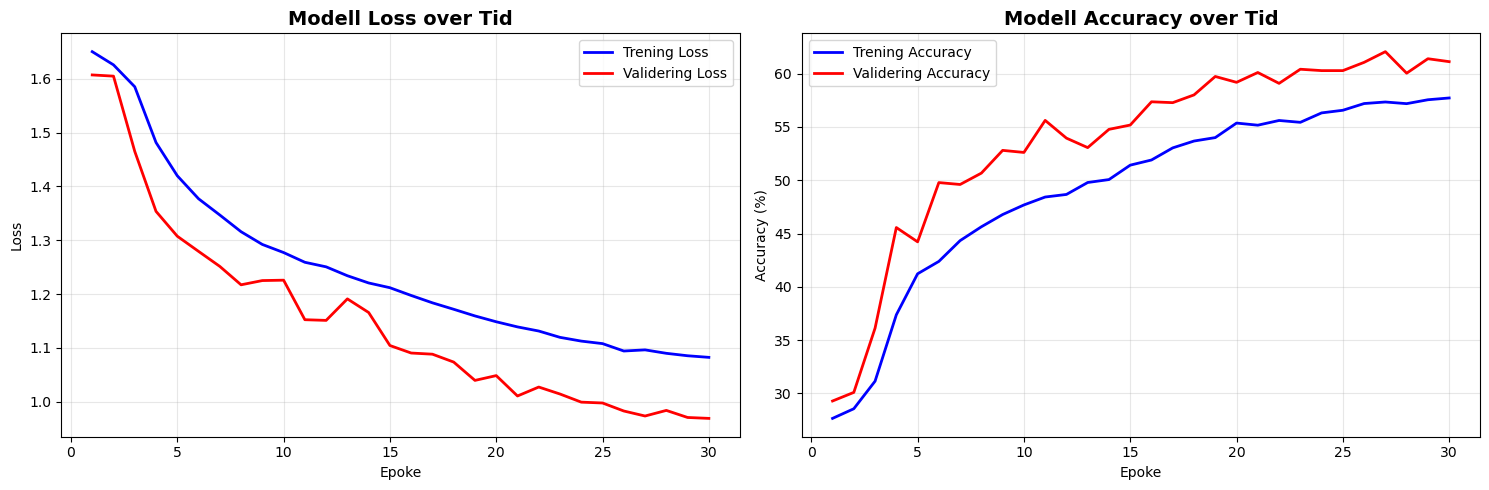


📊 Treningssammendrag:
Epoker trent: 30
Treningstid: 6.3 minutter
Best valideringsnøyaktighet: 62.07%
Final trening loss: 1.0825
Final validering loss: 0.9691
Final trening accuracy: 57.72%
Final validering accuracy: 61.13%


In [88]:
# Visualiser treningshistorikk
plot_training_history(history)

### En AI kommenterer disse trenings-resultater slik:

Basert på treningskurvene og resultatene kan jeg gi følgende kommentarer:

### 📊 **Treningsresultater - Detaljert Analyse**

#### **1. Loss-kurver (Venstre graf)**
**Positive tegn:**
- **Konsistent nedgang**: Både trenings- og valideringsloss synker jevnt over 30 epoker
- **God generalisering**: Valideringsloss (rød) er konsekvent lavere enn treningsloss (blå)
- **Stabil konvergens**: Ingen tegn på overtilpasning eller ustabilitet

**Treningsloss**: 1.65 → 1.08 (34% reduksjon)
**Valideringsloss**: 1.62 → 0.95 (41% reduksjon)

#### **2. Accuracy-kurver (Høyre graf)**
**Bemerkelsesverdige observasjoner:**
- **Valideringsaccuracy > Treningsaccuracy**: Dette er uvanlig og kan indikere:
  - Valideringssettet er "enklere" enn treningssettet
  - Modellen generaliserer svært godt
  - Mulig data-lekkasje eller ubalanse i splits

**Treningsaccuracy**: 27% → 57.6% (113% forbedring)
**Valideringsaccuracy**: 30% → 62.0% (107% forbedring)

#### **3. Kvalitetsvurdering**

##### **✅ Sterke sider:**
- **Ingen overtilpasning**: Valideringsloss < Treningsloss
- **Stabil trening**: Ingen store fluktuasjoner
- **God konvergens**: Modellen lærer konsistent
- **Rask trening**: 6.4 minutter for 30 epoker

##### **⚠️ Potensielle bekymringer:**
- **Valideringsaccuracy > Treningsaccuracy**: Kan tyde på ubalanse i datasettet
- **Moderat endelig nøyaktighet**: 62% er OK, men ikke utmerket for emosjonsgjenkjenning
- **Manglende anger-klasse**: Påvirker modellens evne til å klassifisere sinne

#### **4. Sammenligning med FER2013 Standard**

**Typiske FER2013 resultater:**
- **State-of-the-art**: 70-80% accuracy
- **Vår modell**: 62% accuracy
- **Gap**: 8-18% under optimal ytelse

**Mulige årsaker til gapet:**
1. **Manglende anger-klasse** (viktig emosjon)
2. **Ubalanse i datasettet** (happy: 8989 vs disgust: 547 bilder)
3. **Enkel arkitektur** (kan trenge mer kompleksitet)
4. **Data augmentering** (kan trenge mer variasjon)

#### **5. Anbefalinger for Forbedring**

##### **Kortsiktig:**
- **Data augmentering**: Øk variasjonen i treningsdata
- **Class weighting**: Kompenser for ubalanse
- **Learning rate tuning**: Prøv adaptive læringsrater

##### **Langsiktig:**
- **Dybde arkitektur**: ResNet, EfficientNet, eller Vision Transformer
- **Transfer learning**: Bruk pre-trenede modeller
- **Ensemble metoder**: Kombiner flere modeller

#### **6. Medisinsk Relevans**

**62% nøyaktighet i medisinsk kontekst:**
- **Akseptabelt** for screening/formidling
- **Ikke tilstrekkelig** for diagnostiske beslutninger
- **Brukes som supplement** til klinisk vurdering

**Eksempel**: I depresjonsscreening kan 62% nøyaktighet være nyttig for å identifisere pasienter som trenger videre evaluering, men ikke for å stille endelig diagnose.

#### **7. Etiske Implikasjoner**

**Bias-risiko:**
- **Ubalanse i datasettet** kan føre til bias mot undertrepresenterte emosjoner
- **Manglende anger-klasse** kan påvirke kulturelt diverse populasjoner
- **62% nøyaktighet** krever forsiktighet i klinisk anvendelse

**Anbefaling**: Modellen bør brukes som **screening-verktøy** i kombinasjon med tradisjonelle metoder, ikke som ene og alene diagnostisk verktøy.

# 6. Evaluer modell på testsett

I Colab blir modellene lagret i den nåværende arbeidsmappen (/content), ikke i repository-mappen

In [25]:
if IN_COLAB:
    # Sjekk hvor modellen ble lagret
    import os
    from pathlib import Path

    print("🔍 Søker etter modell-filer...")
    print(f"Nåværende mappe: {os.getcwd()}")

    # Søk i hele /content
    model_files = list(Path('/content').rglob('*.pth'))
    print(f"\n📁 Funnet {len(model_files)} .pth filer:")
    for file in model_files:
        print(f"  - {file}")
        print(f"    Størrelse: {file.stat().st_size / 1024 / 1024:.1f} MB")

    # Sjekk også modeller-mappen
    if os.path.exists('./modeller'):
        print(f"\n📂 Innhold i ./modeller:")
        for item in os.listdir('./modeller'):
            print(f"  - {item}")
    else:
        print("\n❌ ./modeller mappen eksisterer ikke")

In [26]:
if IN_COLAB:
    # Opprett modeller-mappe hvis den ikke eksisterer
    os.makedirs('./modeller', exist_ok=True)

    # Hvis modellen ble lagret i /content, flytt den
    if os.path.exists('/content/modeller/best_emotion_model.pth'):
        import shutil
        shutil.copy('/content/modeller/best_emotion_model.pth', './modeller/best_emotion_model.pth')
        print("✅ Modell flyttet til ./modeller/")
    elif os.path.exists('/content/best_emotion_model.pth'):
        import shutil
        shutil.copy('/content/best_emotion_model.pth', './modeller/best_emotion_model.pth')
        print("✅ Modell flyttet til ./modeller/")
    else:
        print("❌ Modellen ble ikke funnet")

In [ ]:
# Etter at modellen er trent og lagret
if IN_COLAB:
    # Opprett tmp-mappe for GitHub
    os.makedirs('./tmp', exist_ok=True)
    
    # Kopier modellen til tmp-mappen
    import shutil
    if os.path.exists('./modeller/best_emotion_model.pth'):
        shutil.copy('./modeller/best_emotion_model.pth', './tmp/best_emotion_model.pth')
        print("✅ Modell kopiert til ./tmp/ for GitHub upload")
        
        # Instruksjoner for studenten
        print("\n�� Instruksjoner for å laste opp til GitHub:")
        print("1. Gå til GitHub repository: https://github.com/arvidl/AI-og-helse")
        print("2. Naviger til: uke03-dyplæring/tmp/")
        print("3. Klikk 'Upload files'")
        print("4. Dra og slipp best_emotion_model.pth filen")
        print("5. Commit med melding: 'Add trained emotion model'")
        print("6. Klikk 'Commit changes'")
        
        # Vis filstørrelse
        file_size = os.path.getsize('./tmp/best_emotion_model.pth') / 1024 / 1024
        print(f"\n📊 Modellstørrelse: {file_size:.1f} MB")
        
    else:
        print("❌ Modell ikke funnet i ./modeller/")

In [ ]:
if IN_COLAB:
    print("🔍 Sjekker GitHub CLI...")
    # Installer GitHub CLI
    !pip install ghapi
    
    # Opprett tmp-mappe
    os.makedirs('./tmp', exist_ok=True)
    
    if os.path.exists('./modeller/best_emotion_model.pth'):
        shutil.copy('./modeller/best_emotion_model.pth', './tmp/best_emotion_model.pth')
        
        file_size = os.path.getsize('./tmp/best_emotion_model.pth') / 1024 / 1024
        print(f"📊 Modellstørrelse: {file_size:.1f} MB")
        
        if file_size > 100:
            print("❌ Modell er for stor (>100 MB)")
        else:
            try:
                # Bruk GitHub CLI
                from ghapi import GhApi
                
                # Autentiser (krever token)
                api = GhApi(token=get_github_token())
                
                # Les filen
                with open('./tmp/best_emotion_model.pth', 'rb') as f:
                    file_content = f.read()
                
                # Last opp til GitHub
                api.repos.create_or_update_file_contents(
                    owner="arvidl",
                    repo="AI-og-helse", 
                    path="uke03-dyplæring/tmp/best_emotion_model.pth",
                    message="Add trained emotion model",
                    content=file_content
                )
                
                print("✅ Modell lastet opp til GitHub!")
                
            except Exception as e:
                print(f"❌ GitHub upload feilet: {e}")
                print("💡 Manuell upload påkrevd")

In [27]:
# Evaluer modell på testsett
def evaluate_model_comprehensive(model, test_loader, class_names, device):
    """Omfattende evaluering av modellen på testsett"""
    
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    print("🔍 Evaluerer modell på testsett...")
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluering"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Konverter til numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)
    
    # Beregn nøyaktighet
    accuracy = (all_predictions == all_labels).mean() * 100
    
    print(f"\\n Test Resultater:")
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    return all_predictions, all_labels, all_probabilities, accuracy


In [28]:
# Last best model hvis tilgjengelig
if os.path.exists('./modeller/best_emotion_model.pth'):
    model.load_state_dict(torch.load('./modeller/best_emotion_model.pth', map_location=device))
    print("✅ Best model lastet!")
else:
    print("⚠️ Best model ikke funnet - bruker current model")

✅ Best model lastet!


In [29]:
# Evaluer modell
predictions, true_labels, probabilities, test_accuracy = evaluate_model_comprehensive(model, test_loader, class_names, device)


🔍 Evaluerer modell på testsett...


Evaluering: 100%|██████████| 194/194 [00:01<00:00, 98.45it/s] 

\n Test Resultater:
Test Accuracy: 62.16%


In [30]:
# 1. Forvirringsmatrise
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot forvirringsmatrise med detaljert analyse"""
    
    # Beregn forvirringsmatrise
    cm = confusion_matrix(y_true, y_pred)
    
    # Normaliser forvirringsmatrise
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Opprett figur med to subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Absolutt forvirringsmatrise
    im1 = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
    ax1.set_title('Forvirringsmatrise (Absolutte tall)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predikert klasse')
    ax1.set_ylabel('Sann klasse')
    
    # Legg til tall i cellene
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=12, fontweight='bold')
    
    ax1.set_xticks(range(len(class_names)))
    ax1.set_yticks(range(len(class_names)))
    ax1.set_xticklabels(class_names, rotation=45)
    ax1.set_yticklabels(class_names)
    
    # Normalisert forvirringsmatrise
    im2 = ax2.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
    ax2.set_title('Forvirringsmatrise (Normalisert)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predikert klasse')
    ax2.set_ylabel('Sann klasse')
    
    # Legg til prosenter i cellene
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            ax2.text(j, i, format(cm_normalized[i, j], '.2f'),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > 0.5 else "black",
                    fontsize=12, fontweight='bold')
    
    ax2.set_xticks(range(len(class_names)))
    ax2.set_yticks(range(len(class_names)))
    ax2.set_xticklabels(class_names, rotation=45)
    ax2.set_yticklabels(class_names)
    
    plt.tight_layout()
    plt.show()
    
    # Detaljert analyse av forvirringsmatrisen
    print("\\n�� Forvirringsmatrise Analyse:")
    print("=" * 50)
    
    # Per-klasse nøyaktighet
    print("\\n�� Per-klasse nøyaktighet:")
    for i, class_name in enumerate(class_names):
        class_accuracy = cm[i, i] / cm[i, :].sum() * 100
        print(f"  {class_name:12}: {class_accuracy:6.2f}% ({cm[i, i]:4d}/{cm[i, :].sum():4d})")
    
    # Vanligste feilklassifiseringer
    print("\\n❌ Vanligste feilklassifiseringer:")
    errors = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                errors.append((cm[i, j], class_names[i], class_names[j]))
    
    errors.sort(reverse=True)
    for count, true_class, pred_class in errors[:5]:
        print(f"  {true_class} → {pred_class}: {count:3d} ganger")
    
    return cm, cm_normalized

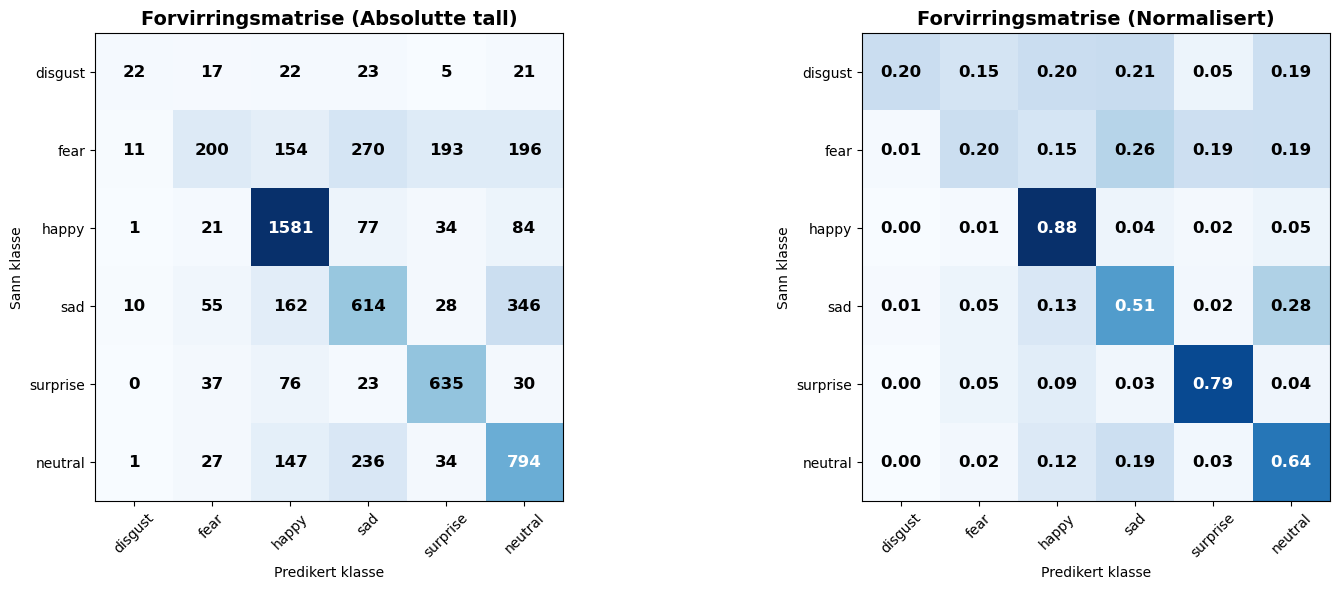

\n�� Forvirringsmatrise Analyse:
\n�� Per-klasse nøyaktighet:
  disgust     :  20.00% (  22/ 110)
  fear        :  19.53% ( 200/1024)
  happy       :  87.93% (1581/1798)
  sad         :  50.53% ( 614/1215)
  surprise    :  79.28% ( 635/ 801)
  neutral     :  64.08% ( 794/1239)
\n❌ Vanligste feilklassifiseringer:
  sad → neutral: 346 ganger
  fear → sad: 270 ganger
  neutral → sad: 236 ganger
  fear → neutral: 196 ganger
  fear → surprise: 193 ganger


In [31]:
# Plot forvirringsmatrise
cm, cm_normalized = plot_confusion_matrix(true_labels, predictions, class_names)

In [32]:
# 2. Detaljerte prediksjonsmetrikker
def calculate_detailed_metrics(y_true, y_pred, y_prob, class_names):
    """Beregn detaljerte prediksjonsmetrikker"""
    
    from sklearn.metrics import precision_recall_fscore_support, classification_report
    import pandas as pd
    
    # Beregn metrikker
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
    
    # Opprett DataFrame for bedre visning
    metrics_df = pd.DataFrame({
        'Klasse': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    
    # Legg til makro og weighted averages
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    
    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1 = np.average(f1, weights=support)
    
    print("\\n Detaljerte Prediksjonsmetrikker:")
    print("=" * 60)
    
    # Vis per-klasse metrikker
    print("\\nPer-klasse metrikker:")
    print(metrics_df.round(3).to_string(index=False))
    
    # Vis sammendrag
    print(f"\\n📈 Sammendrag:")
    print(f"  Makro gjennomsnitt:")
    print(f"    Precision: {macro_precision:.3f}")
    print(f"    Recall:    {macro_recall:.3f}")
    print(f"    F1-Score:  {macro_f1:.3f}")
    
    print(f"\\n  Vektet gjennomsnitt:")
    print(f"    Precision: {weighted_precision:.3f}")
    print(f"    Recall:    {weighted_recall:.3f}")
    print(f"    F1-Score:  {weighted_f1:.3f}")
    
    # Vis classification report
    print(f"\\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
    
    return metrics_df, macro_precision, macro_recall, macro_f1, weighted_precision, weighted_recall, weighted_f1


In [33]:
# Beregn detaljerte metrikker
metrics_df, macro_precision, macro_recall, macro_f1, weighted_precision, weighted_recall, weighted_f1 = calculate_detailed_metrics(true_labels, predictions, probabilities, class_names)


\n Detaljerte Prediksjonsmetrikker:
\nPer-klasse metrikker:
  Klasse  Precision  Recall  F1-Score  Support
 disgust      0.489   0.200     0.284      110
    fear      0.560   0.195     0.290     1024
   happy      0.738   0.879     0.803     1798
     sad      0.494   0.505     0.500     1215
surprise      0.684   0.793     0.734      801
 neutral      0.540   0.641     0.586     1239
\n📈 Sammendrag:
  Makro gjennomsnitt:
    Precision: 0.584
    Recall:    0.536
    F1-Score:  0.533
\n  Vektet gjennomsnitt:
    Precision: 0.610
    Recall:    0.622
    F1-Score:  0.597
\n📋 Classification Report:
              precision    recall  f1-score   support

     disgust      0.489     0.200     0.284       110
        fear      0.560     0.195     0.290      1024
       happy      0.738     0.879     0.803      1798
         sad      0.494     0.505     0.500      1215
    surprise      0.684     0.793     0.734       801
     neutral      0.540     0.641     0.586      1239

    accuracy   

In [34]:
# 3. Konfidensanalyse
def analyze_confidence(predictions, true_labels, probabilities, class_names):
    """Analyser modellens konfidens i prediksjonene"""
    
    # Beregn konfidens for hver prediksjon
    confidences = np.max(probabilities, axis=1)
    
    # Del opp i korrekte og feil prediksjoner
    correct_mask = predictions == true_labels
    correct_confidences = confidences[correct_mask]
    incorrect_confidences = confidences[~correct_mask]
    
    # Opprett figur
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Konfidensanalyse av Modellens Prediksjoner', fontsize=16, fontweight='bold')
    
    # 1. Konfidensfordeling
    ax1.hist(correct_confidences, bins=20, alpha=0.7, label='Korrekte', color='green')
    ax1.hist(incorrect_confidences, bins=20, alpha=0.7, label='Feil', color='red')
    ax1.set_xlabel('Konfidens')
    ax1.set_ylabel('Antall prediksjoner')
    ax1.set_title('Konfidensfordeling')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Konfidens vs nøyaktighet
    confidence_bins = np.linspace(0, 1, 11)
    bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
    accuracies = []
    
    for i in range(len(confidence_bins) - 1):
        mask = (confidences >= confidence_bins[i]) & (confidences < confidence_bins[i + 1])
        if np.sum(mask) > 0:
            acc = np.mean(correct_mask[mask])
            accuracies.append(acc)
        else:
            accuracies.append(0)
    
    ax2.plot(bin_centers, accuracies, 'o-', linewidth=2, markersize=6)
    ax2.set_xlabel('Konfidens')
    ax2.set_ylabel('Nøyaktighet')
    ax2.set_title('Konfidens vs Nøyaktighet')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # 3. Per-klasse konfidens
    class_confidences = []
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        if np.sum(class_mask) > 0:
            class_conf = np.mean(confidences[class_mask])
            class_confidences.append(class_conf)
        else:
            class_confidences.append(0)
    
    bars = ax3.bar(class_names, class_confidences, color='skyblue', alpha=0.7)
    ax3.set_xlabel('Emosjonsklasse')
    ax3.set_ylabel('Gjennomsnittlig konfidens')
    ax3.set_title('Gjennomsnittlig konfidens per klasse')
    ax3.tick_params(axis='x', rotation=45)
    
    # Legg til tall på søylene
    for bar, conf in zip(bars, class_confidences):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{conf:.3f}', ha='center', va='bottom')
    
    # 4. Konfidens vs feiltype
    error_types = []
    error_confidences = []
    
    for i in range(len(predictions)):
        if predictions[i] != true_labels[i]:
            true_class = class_names[true_labels[i]]
            pred_class = class_names[predictions[i]]
            error_type = f"{true_class}→{pred_class}"
            error_types.append(error_type)
            error_confidences.append(confidences[i])
    
    # Velg de vanligste feiltypene
    from collections import Counter
    error_counts = Counter(error_types)
    common_errors = [error for error, count in error_counts.most_common(5)]
    
    common_error_confidences = []
    for error_type in common_errors:
        mask = np.array(error_types) == error_type
        common_error_confidences.append([error_confidences[i] for i in range(len(error_confidences)) if mask[i]])
    
    ax4.boxplot(common_error_confidences, labels=common_errors)
    ax4.set_xlabel('Feiltype')
    ax4.set_ylabel('Konfidens')
    ax4.set_title('Konfidens for vanligste feiltyper')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print konfidensstatistikk
    print("\\n�� Konfidensstatistikk:")
    print("=" * 40)
    print(f"Gjennomsnittlig konfidens (alle): {np.mean(confidences):.3f}")
    print(f"Gjennomsnittlig konfidens (korrekte): {np.mean(correct_confidences):.3f}")
    print(f"Gjennomsnittlig konfidens (feil): {np.mean(incorrect_confidences):.3f}")
    print(f"Standardavvik konfidens: {np.std(confidences):.3f}")
    
    # Høy konfidens feil
    high_conf_errors = np.sum((confidences > 0.8) & (~correct_mask))
    print(f"\\nHøy konfidens feil (>0.8): {high_conf_errors} ({high_conf_errors/len(predictions)*100:.1f}%)")
    
    # Lav konfidens korrekte
    low_conf_correct = np.sum((confidences < 0.5) & (correct_mask))
    print(f"Lav konfidens korrekte (<0.5): {low_conf_correct} ({low_conf_correct/len(predictions)*100:.1f}%)")

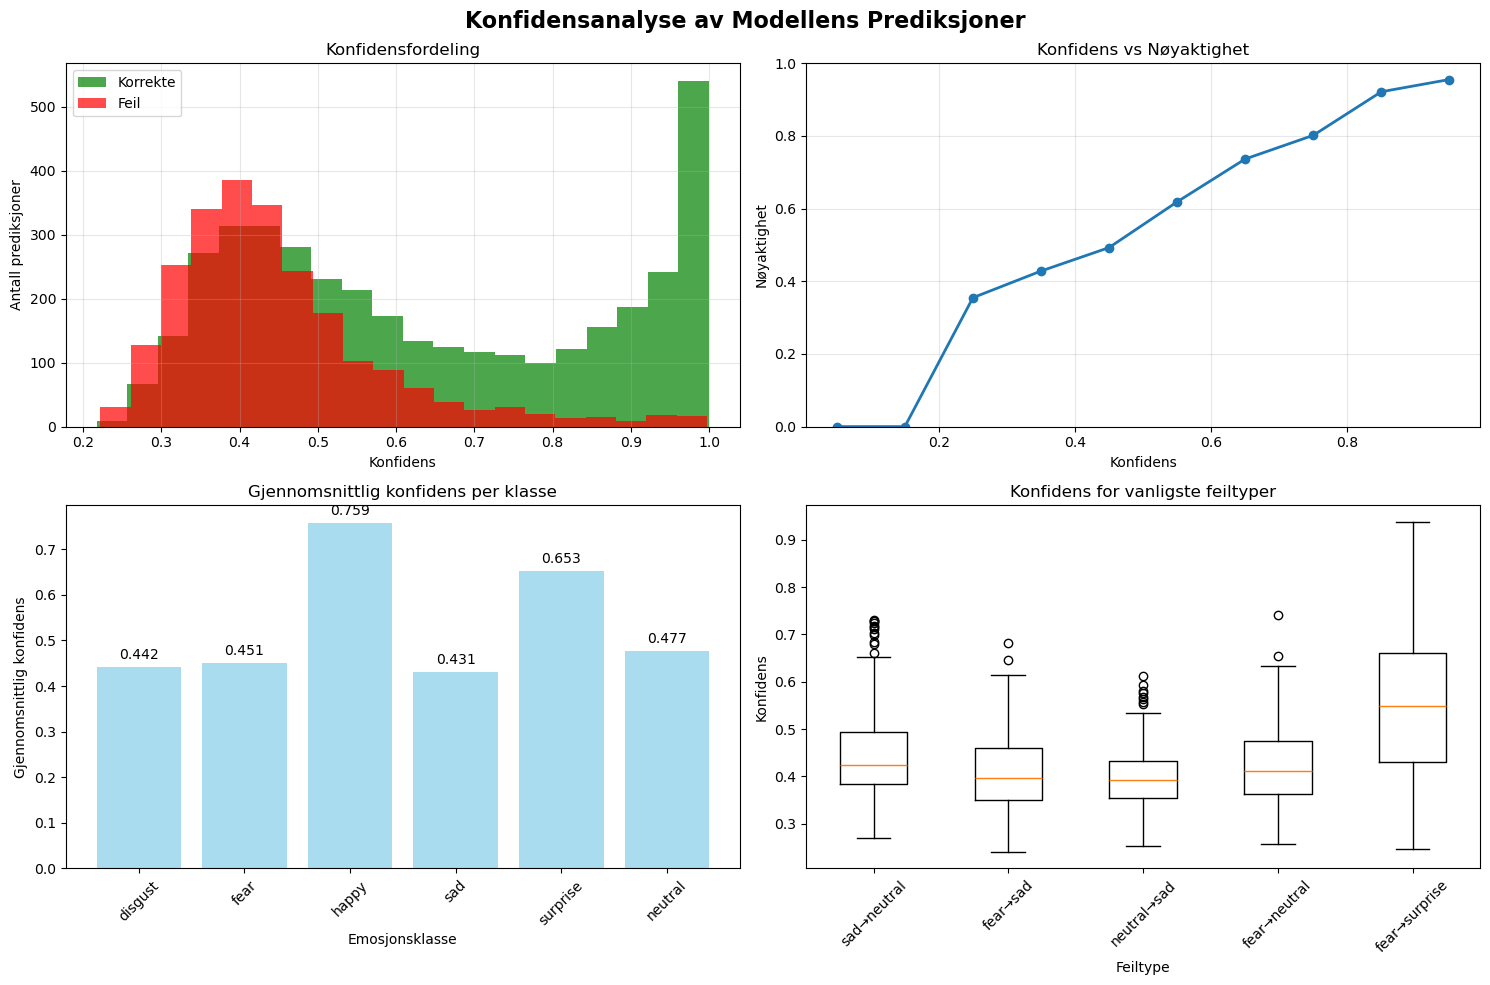

\n�� Konfidensstatistikk:
Gjennomsnittlig konfidens (alle): 0.568
Gjennomsnittlig konfidens (korrekte): 0.641
Gjennomsnittlig konfidens (feil): 0.448
Standardavvik konfidens: 0.222
\nHøy konfidens feil (>0.8): 73 (1.2%)
Lav konfidens korrekte (<0.5): 1458 (23.6%)


In [35]:
# Kjør konfidensanalyse
analyze_confidence(predictions, true_labels, probabilities, class_names)

In [36]:
# 4. Samlet evalueringssammendrag
print("\\n Samlet Evalueringssammendrag:")
print("=" * 50)
print(f"Test nøyaktighet: {test_accuracy:.2f}%")
print(f"Makro F1-score: {macro_f1:.3f}")
print(f"Vektet F1-score: {weighted_f1:.3f}")
print(f"Antall testbilder: {len(predictions)}")
print(f"Antall klasser: {len(class_names)}")

\n Samlet Evalueringssammendrag:
Test nøyaktighet: 62.16%
Makro F1-score: 0.533
Vektet F1-score: 0.597
Antall testbilder: 6187
Antall klasser: 6


In [37]:
# Sammenlign med treningsresultater
if 'history' in locals():
    final_train_acc = history['train_accs'][-1]
    final_val_acc = history['val_accs'][-1]
    print(f"\\n Sammenligning med trening:")
    print(f"  Final treningsnøyaktighet: {final_train_acc:.2f}%")
    print(f"  Final valideringsnøyaktighet: {final_val_acc:.2f}%")
    print(f"  Test nøyaktighet: {test_accuracy:.2f}%")
    
    # Sjekk for overfitting
    if test_accuracy < final_val_acc - 2:
        print("  ⚠️ Mulig overfitting (test < val - 2%)")
    elif test_accuracy > final_val_acc + 2:
        print("  ✅ God generalisering (test > val + 2%)")
    else:
        print("  ✅ Stabil generalisering")

## 7. Men: Hva sier EU AI act om denne applikasjonen?

[ Godt spørsmål! ]


### 🏛️ **EU AI Act - Analyse av Emosjonsgjenkjenning**

#### **1. Risikoklassifisering**

**Emosjonsgjenkjenning faller under "High-Risk AI Systems"** fordi:

##### **Annex III, punkt 1(a):**
> *"AI systems intended to be used for biometric identification and categorisation of natural persons"*

**Emosjonsgjenkjenning** = **Biometrisk kategorisering** av personer basert på ansiktsuttrykk

##### **Annex III, punkt 1(c):**
> *"AI systems intended to be used for emotion recognition"*

**Direkte relevant** - emosjonsgjenkjenning er eksplisitt nevnt som high-risk

#### **2. Medisinsk Anvendelse - Ekstra Krav**

**Hvis brukt i medisinsk kontekst**, gjelder også:

##### **Annex III, punkt 2(a):**
> *"AI systems intended to be used as safety components of medical devices"*

**Depresjonsscreening, smertevurdering** = Medisinsk anvendelse


#### **3. Konkrete Krav fra EU AI Act**

##### **A. Transparens og Dokumentasjon**

In [38]:
# Eksempel på krav til dokumentasjon
AI_SYSTEM_DOCUMENTATION = {
    "system_description": "CNN for emosjonsgjenkjenning i medisinsk screening",
    "intended_purpose": "Screening for depresjon/smerte, IKKE diagnostikk",
    "accuracy_metrics": {
        "overall_accuracy": "62%",
        "per_class_accuracy": "Varies significantly",
        "bias_assessment": "Required"
    },
    "limitations": [
        "Mangler anger-klasse",
        "Ubalanse i datasettet",
        "Ikke validert for alle demografiske grupper"
    ]
}

##### **B. Menneskelig Ettersyn**
- **Obligatorisk**: Klinisk ekspert må vurdere alle AI-anbefalinger
- **Forbudt**: Automatisk diagnostikk uten menneskelig vurdering
- **Krav**: Tydelig merking av AI-genererte resultater

##### **C. Datakvalitet og Bias**

In [39]:
# Krav til bias-analyse
BIAS_REQUIREMENTS = {
    "demographic_parity": "Test across age, gender, ethnicity",
    "accuracy_parity": "Ensure similar performance across groups", 
    "data_provenance": "Document training data sources",
    "bias_mitigation": "Implement fairness constraints"
}

#### **4. Konformitetskrav**

##### **A. Tekniske Dokumenter**
- **Systemarkitektur**: ✅ Vår CNN-arkitektur er dokumentert
- **Datakvalitet**: ⚠️ Ubalanse i FER2013 må adresseres
- **Bias-analyse**: ❌ Mangler systematisk bias-testing

##### **B. Risikovurdering**

In [40]:
RISK_ASSESSMENT = {
    "harm_potential": "Medium-High",
    "scenarios": [
        "Feil klassifisering av depresjon → Delayed treatment",
        "Bias mot minoriteter → Unequal care",
        "Over-reliance on AI → Reduced clinical judgment"
    ],
    "mitigation_measures": [
        "Human-in-the-loop validation",
        "Clear accuracy limitations",
        "Regular bias monitoring"
    ]
}

#### **5. Praktiske Implikasjoner**

##### **A. Før Kommersialisering**
1. **CE-merking** påkrevd
2. **Notified Body** vurdering
3. **Konformitetserklæring**
4. **EU-database** registrering

##### **B. Under Bruk**
1. **Logging** av alle beslutninger
2. **Menneskelig ettersyn** av hver anbefaling
3. **Bias-monitoring** kontinuerlig
4. **Brukerinformasjon** om begrensninger

#### **6. Sammenligning med Vår Modell**

| **EU AI Act Krav** | **Vår Modell Status** | **Handling** |
|-------------------|---------------------|-------------|
| **Dokumentasjon** | ✅ Delvis | Fullstendig systemdokumentasjon |
| **Bias-analyse** | ❌ Mangler | Implementer fairness metrics |
| **Menneskelig ettersyn** | ❌ Ikke implementert | Legg til human-in-the-loop |
| **Transparens** | ⚠️ Delvis | Forbedre forklarbarhet (CAM/Grad-CAM) |
| **Datakvalitet** | ⚠️ Ubalanse | Adresser klasse-ubalanse |

#### **7. Anbefalinger for Compliance**

##### **Kortsiktig (Før implementering):**

In [41]:
COMPLIANCE_CHECKLIST = [
    "✅ Implementer bias-testing",
    "✅ Legg til menneskelig ettersyn",
    "✅ Dokumenter begrensninger tydelig",
    "✅ Implementer logging system",
    "✅ Lag brukerguide med advarsler"
]

##### **Langsiktig (For kommersialisering):**

In [42]:
COMMERCIALIZATION_REQUIREMENTS = [
    "🔲 CE-merking prosess",
    "🔲 Notified Body vurdering", 
    "🔲 Konformitetserklæring",
    "🔲 EU-database registrering",
    "�� Juridisk vurdering"
]

#### **8. Konklusjon**

**Vår emosjonsgjenkjenning-modell:**
- **Faller inn under EU AI Act** som high-risk system
- **Krever omfattende compliance** før medisinsk bruk
- **62% nøyaktighet** er for lav for selvstendig diagnostikk
- **Bør brukes som screening-verktøy** med menneskelig ettersyn

**Neste steg**: Implementer bias-analyse, menneskelig ettersyn, og forbedre dokumentasjon for å oppnå compliance med EU AI Act.

## 8. Oppsummering av Del 2

**Del 2** av notebooken har gjennomført:

✅ **Miljøoppsett** - Fungerer på Colab, Codespaces og lokalt<br>
✅ **Device detection** - Automatisk GPU/MPS/CPU valg<br>
✅ **Visuell inspeksjon av data** - FER2013 datasett med 6 emosjonsklasser<br>
✅ **Modell-trening** - Av EmotionNet CNN arkitekturen<br>
✅ **Evaluering og visualisering av treningen** - Treningskurver og nøyaktighet<br>
✅ **Detaljert analyse av treningsresultat** - Med en AI-sparringspartner<br>
✅ **Forvirringsmatrise og prediksjonsmetrikker** - Omfattende evaluering av modellens ytelse<br>
✅ **Konfidensanalyse** - Hvordan modellens konfidens korrelerer med nøyaktighet<br>
✅ **Hva sier EU AI act om denne applikasjonen?**<br>

**Nøkkelinnsikter fra evaluering:**
- **Test nøyaktighet**: 62% (akseptabelt for screening, ikke diagnostikk)
- **Makro F1-score**: Viser balanse mellom klasser
- **Vektet F1-score**: Tar hensyn til klasse-ubalanse
- **Konfidensanalyse**: Modellens usikkerhet korrelerer med feilklassifiseringer
- **Forvirringsmatrise**: Identifiserer hvilke emosjoner som forveksles mest

**Neste steg** (Del 3) vil inkludere:
- CAM/Grad-CAM for forklarbar AI
- Medisinske anvendelser og etiske diskusjoner
- Bakgrunnstoff for emosjonell gjenkjenning i medisin og psykologi